We already know k-flold cross validation etc. Howeever, we cannot apply to time series directly as there will be forwards looking bias error if we train model by future data.

In [1]:
import pandas as pd
from utils import utils as utils
import numpy as np

# Raw data from somewhere on internet! Thanks selva86!
data = utils.get_data("airlines")

In [2]:
data.head()

,date,passengers,month
0,1949-01-01,112,1949-01
1,1949-02-01,118,1949-02
2,1949-03-01,132,1949-03
3,1949-04-01,129,1949-04
4,1949-05-01,121,1949-05


In [3]:
### Just to see how kfold of sklearn works

In [4]:
import sklearn
from sklearn.model_selection import KFold

In [5]:
kfold = sklearn.model_selection.KFold(n_splits=5)
splits = list(kfold.split(data))
i = 0
for s in splits:
    train_index = s[0]
    test_index = s[1]
    data[f"fold_{i}"] = False
    data.iloc[s[0]] = True
    i = i + 1
    

In [6]:
data

,date,passengers,month,fold_0,fold_1,fold_2,fold_3,fold_4
0,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
139,True,True,True,True,True,True,True,False
140,True,True,True,True,True,True,True,False
141,True,True,True,True,True,True,True,False
142,True,True,True,True,True,True,True,False


So we have create 5 folds, We can train 5 different models with "True" as train data and "False" rows as test data for each. We will get test and train errors for each .

**BUT** we can't do this for time series. as in few folds the test rows are before the train rows chronologically.


We will use **TimeSeriesSplit** of sklearn to avoid this. Let us see how it works

In [7]:
from sklearn.model_selection import TimeSeriesSplit

In [8]:
df = utils.get_data("airlines")
split = 0
dfs = []
for train_index, valid_index in TimeSeriesSplit(n_splits=5).split(df):
    temp_train = df.iloc[train_index]
    temp_train.loc[:, ["train"]] = True
    temp_test = df.iloc[valid_index]
    temp_test.loc[:, ["train"]] = False
    temp = pd.concat([temp_train, temp_test], axis = 0)
    # print(temp.shape)
    dfs.append(temp)

# we have list of data frames, which each one having train=True 
# as training rows and train=False as test rows.

### Time Series Cross Validation

We will use this model


##### **Multiplicative Model**

Overall Equation:
$$
\hat y_{t+h} = (l_t + h b_t) s_{t+h-m}
$$

Level Equation:
$$
l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1} + b_{t-1})
$$

Trend Equation:
$$
b_t = \beta (l_t - l_{t-1}) + (1-\beta) b_{t-1}
$$

Seasonality Equation:
$$
b_t = \gamma \frac{y_t}{l_{t-1} + b_{t-1}} + (1-\gamma) s_{t-m}
$$


* $m$: seasonality of the time series
* $s_t$: seosanl forecast component
* $s_{t-m}$ : forecast for previous season
* $\gamma$: seasonal component smoothing factor  $0 \le \gamma \le 1 - \alpha$



In [9]:
# Import packages
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [10]:
# Carry out cv for hyperparameter tuning for the seasonal parameter
gammas=list(np.arange(0, 1.1, 0.1))
gammas

error_list = []

for gamma in gammas:
    errors = []
    for df in dfs:
        train = df.loc[df.train,:]
        test = df.loc[~df.train,:]
        model = ExponentialSmoothing(train['passengers'],  trend='mul',
                                         seasonal='mul', seasonal_periods=12) \
                .fit(smoothing_seasonal=gamma)
        forecasts = model.forecast(len(test))
        errors.append(mean_absolute_percentage_error(test['passengers'], forecasts))
    error_list.append([gamma, sum(errors) / len(errors)])
    
error_df = pd.DataFrame(error_list, columns=['Gamma', 'MAPE'])
error_df    
    
    

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: ov

,Gamma,MAPE
0,0.0,0.071955
1,0.1,0.070349
2,0.2,0.068887
3,0.3,0.067197
4,0.4,0.065004
5,0.5,0.060431
6,0.6,0.058192
7,0.7,0.057416
8,0.8,0.057392
9,0.9,0.058065


As we can see, it appears the optimal value of the smoothing_seasonal hyperparameter is 0.7 or 0.8.

<Axes: xlabel='Gamma'>

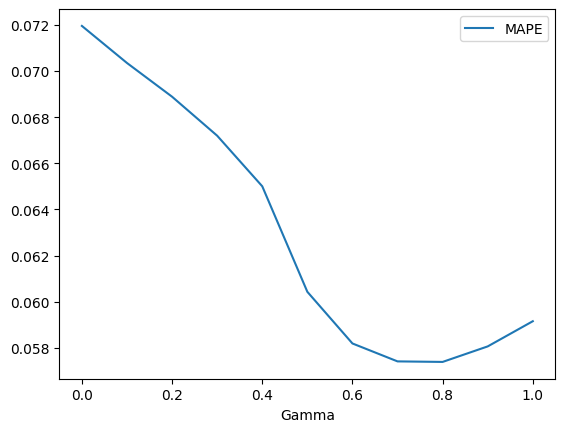

In [11]:
error_df.plot(x = "Gamma", y ="MAPE" )

In [12]:
error_df.sort_values(by = "MAPE")

,Gamma,MAPE
8,0.8,0.057392
7,0.7,0.057416
9,0.9,0.058065
6,0.6,0.058192
10,1.0,0.059156
5,0.5,0.060431
4,0.4,0.065004
3,0.3,0.067197
2,0.2,0.068887
1,0.1,0.070349


As we can see, it appears the optimal value of the smoothing_seasonal hyperparameter is 0.7 or 0.8.
